In [2]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False
batch_size=16


pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


In [4]:
import numpy as np

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(n_class * label_true[mask].astype(int) + label_pred[mask],
                        minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(hist):
    """
    Returns accuracy score evaluation result.
      - [acc]: overall accuracy
      - [acc_cls]: mean accuracy
      - [mean_iu]: mean IU
      - [fwavacc]: fwavacc
    """
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)

    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc


def add_hist(hist, label_trues, label_preds, n_class):
    """
        stack hist(confusion matrix)
    """

    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)

    return hist

In [5]:
%matplotlib inline

dataset_path = '/opt/ml/input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Background"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
category_names = list(sorted_df.Categories)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


In [8]:
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        # images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            # masks = masks.astype(np.float32)
            

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
                
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

loading annotations into memory...
Done (t=3.59s)
creating index...
index created!
image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Background'}, {'Plastic bag', 9}]


Text(0.5, 1.0, 'masks : batch_01_vt/0486.jpg')

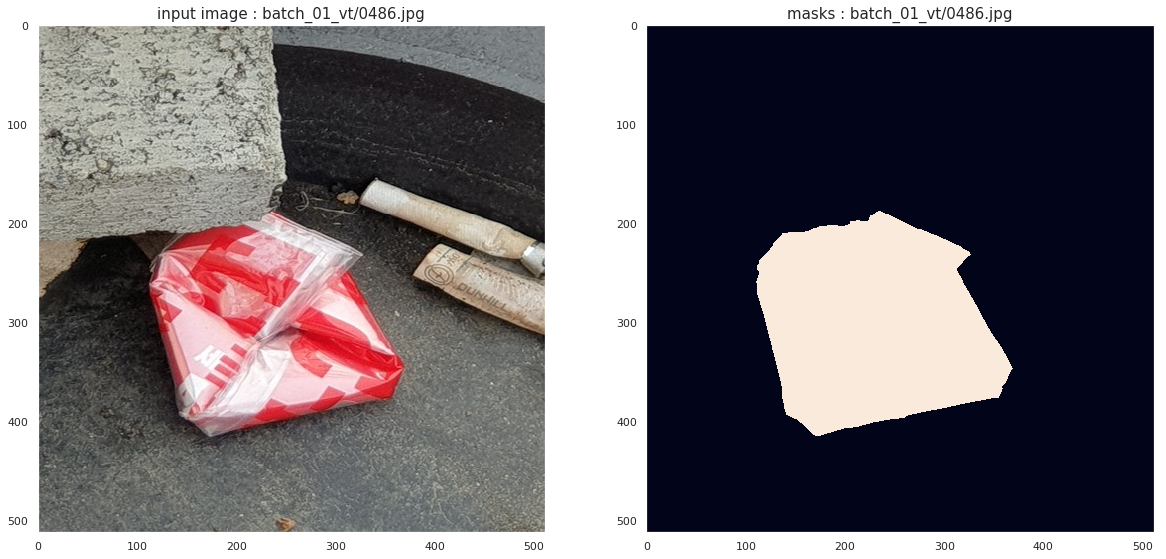

In [21]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            # A.Flip(30, p=1.0),
                            # A.RandomFog(p=1.0),
                            # A.CLAHE((0,5), p=1.0), #int8만 사용가능
                            # A.HueSaturationValue(p=1.0),
                            # A.Cutout(num_holes=50, p=1.0),
                            # A.ColorJitter(p=1.0),
                            # A.GaussNoise(var_limit=(0,100), p=1.0),
                            # A.GridDistortion(num_steps=8, p=1.0),
                            # A.HorizontalFlip(p=1.0),
                            # A.Transpose(p=1.0),
                            # A.RandomResizedCrop(height=512, width=512, p=1.0),
                            # A.Blur(always_apply=True), # 사용못할듯?
                            # A.CenterCrop(500, 500),
                            # A.ChannelDropout(),
                            # A.Normalize(
                            #     mean=(0.485, 0.456, 0.406),
                            #     std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                            # ),                 
                            # A.RandomCropNearBBox(max_part_shift=0.5, p=1.0),
                            # A.Resize(height=512, width=512, p=1.0),  
                            A.CropNonEmptyMaskIfExists(height=512, width=512, p=1.0),                  
                            ToTensorV2(transpose_mask=True)
                          ])

train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

In [20]:
# train_tranform = A.Compose([A.CLAHE(p=p[0]), #int8만 사용가능
#                             A.Blur(p=p[1]), # 사용못할듯?
#                             A.CenterCrop(500, 500, p=p[2]),
#                             A.ChannelDropout(p=p[3]),
#                             A.ChannelShuffle(p=p[4]),
#                             A.CoarseDropout(p=p[5]),
#                             A.ColorJitter(p=p[6]),
#                             A.Cutout(p=p[7]),
#                             A.Downscale(p=p[8]),
#                             A.Equalize(p=p[9]),
#                             A.FancyPCA(p=p[10]),
#                             A.Flip(p=p[11]),
#                             A.GaussianBlur(p=p[12]),
#                             A.GaussNoise(p=p[13]),
#                             A.GlassBlur(p=p[14]),
#                             A.GridDistortion(p=p[15]),
#                             A.GridDropout(p=p[16]),
#                             A.HorizontalFlip(p=p[17]),
#                             A.HueSaturationValue(p=p[18]),
#                             A.ImageCompression(p=p[19]),
#                             A.ISONoise(p=p[20]),
#                             A.MaskDropout(p=p[21]),
#                             A.MultiplicativeNoise(p=p[22]),
#                             A.MotionBlur(p=p[23]),
#                             A.MedianBlur(p=p[24]),
#                             A.OpticalDistortion(p=p[25]),
#                             A.PadIfNeeded(p=p[26]),
#                             A.Posterize(p=p[27]),
#                             A.RandomBrightness(p=p[28]),
#                             A.RandomBrightnessContrast(p=p[29]),
#                             A.RandomContrast(p=p[30]),
#                             A.RandomFog(p=p[31]),
#                             A.RandomGamma(p=p[32]),
#                             A.RandomGridShuffle(p=p[33]),
#                             A.RandomRain(p=p[34]),
#                             A.RandomShadow(p=p[35]),
#                             A.RandomSnow(p=p[36]),
#                             A.RandomSunFlare(p=p[37]),
#                             A.RGBShift(p=p[38]),
#                             A.Solarize(p=p[39]),
#                             A.ToGray(p=p[40]),
#                             A.ToSepia(p=p[41]),
#                             A.VerticalFlip(p=p[42]),
#                             A.Transpose(p=p[43]),
#                             # A.Normalize(
#                             #     mean=(0.485, 0.456, 0.406),
#                             #     std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
#                             # ),                                      
#                             ToTensorV2(transpose_mask=True),
#                         ])